# Modelli ML - E2E

In questa lezione ci occuperemo di allenare e testare diversi modelli di machine learning, in particolare in un contesto di classificazione, sui dati preparati in precedenza.

In [15]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

## Import dati

Per prima cosa importiamo i dataset di train e test preparati durante la lezione scorsa.

In [16]:
# Definiamo una funzione, utilizzando la sintassi "lambda", per costruire i path che ci servono.
join_paths = lambda csv_path: os.path.join("datasets", csv_path)

train_path = join_paths("train.csv")
test_path = join_paths("test.csv")

# importiamo ora i dati in due DataFrame distinti
train_df, test_df = pd.read_csv(train_path), pd.read_csv(test_path)

display(train_path, test_path)

'datasets/train.csv'

'datasets/test.csv'

In [17]:
# Fissiamo la variabile target
CLASSIFICATION_TARGET = "banking_crisis"
REGRESSION_TARGET = "inflation_annual_cpi"
targets = [CLASSIFICATION_TARGET, REGRESSION_TARGET]

# Visualizzazione

Prima di procedere con il training dei modelli applichiamo alcuni metodi di visualizzazione al nostro train set. Utilizzando il metodo `sns.pairplot` viene mostrata la distribuzione congiunta di ogni coppia di variabili:

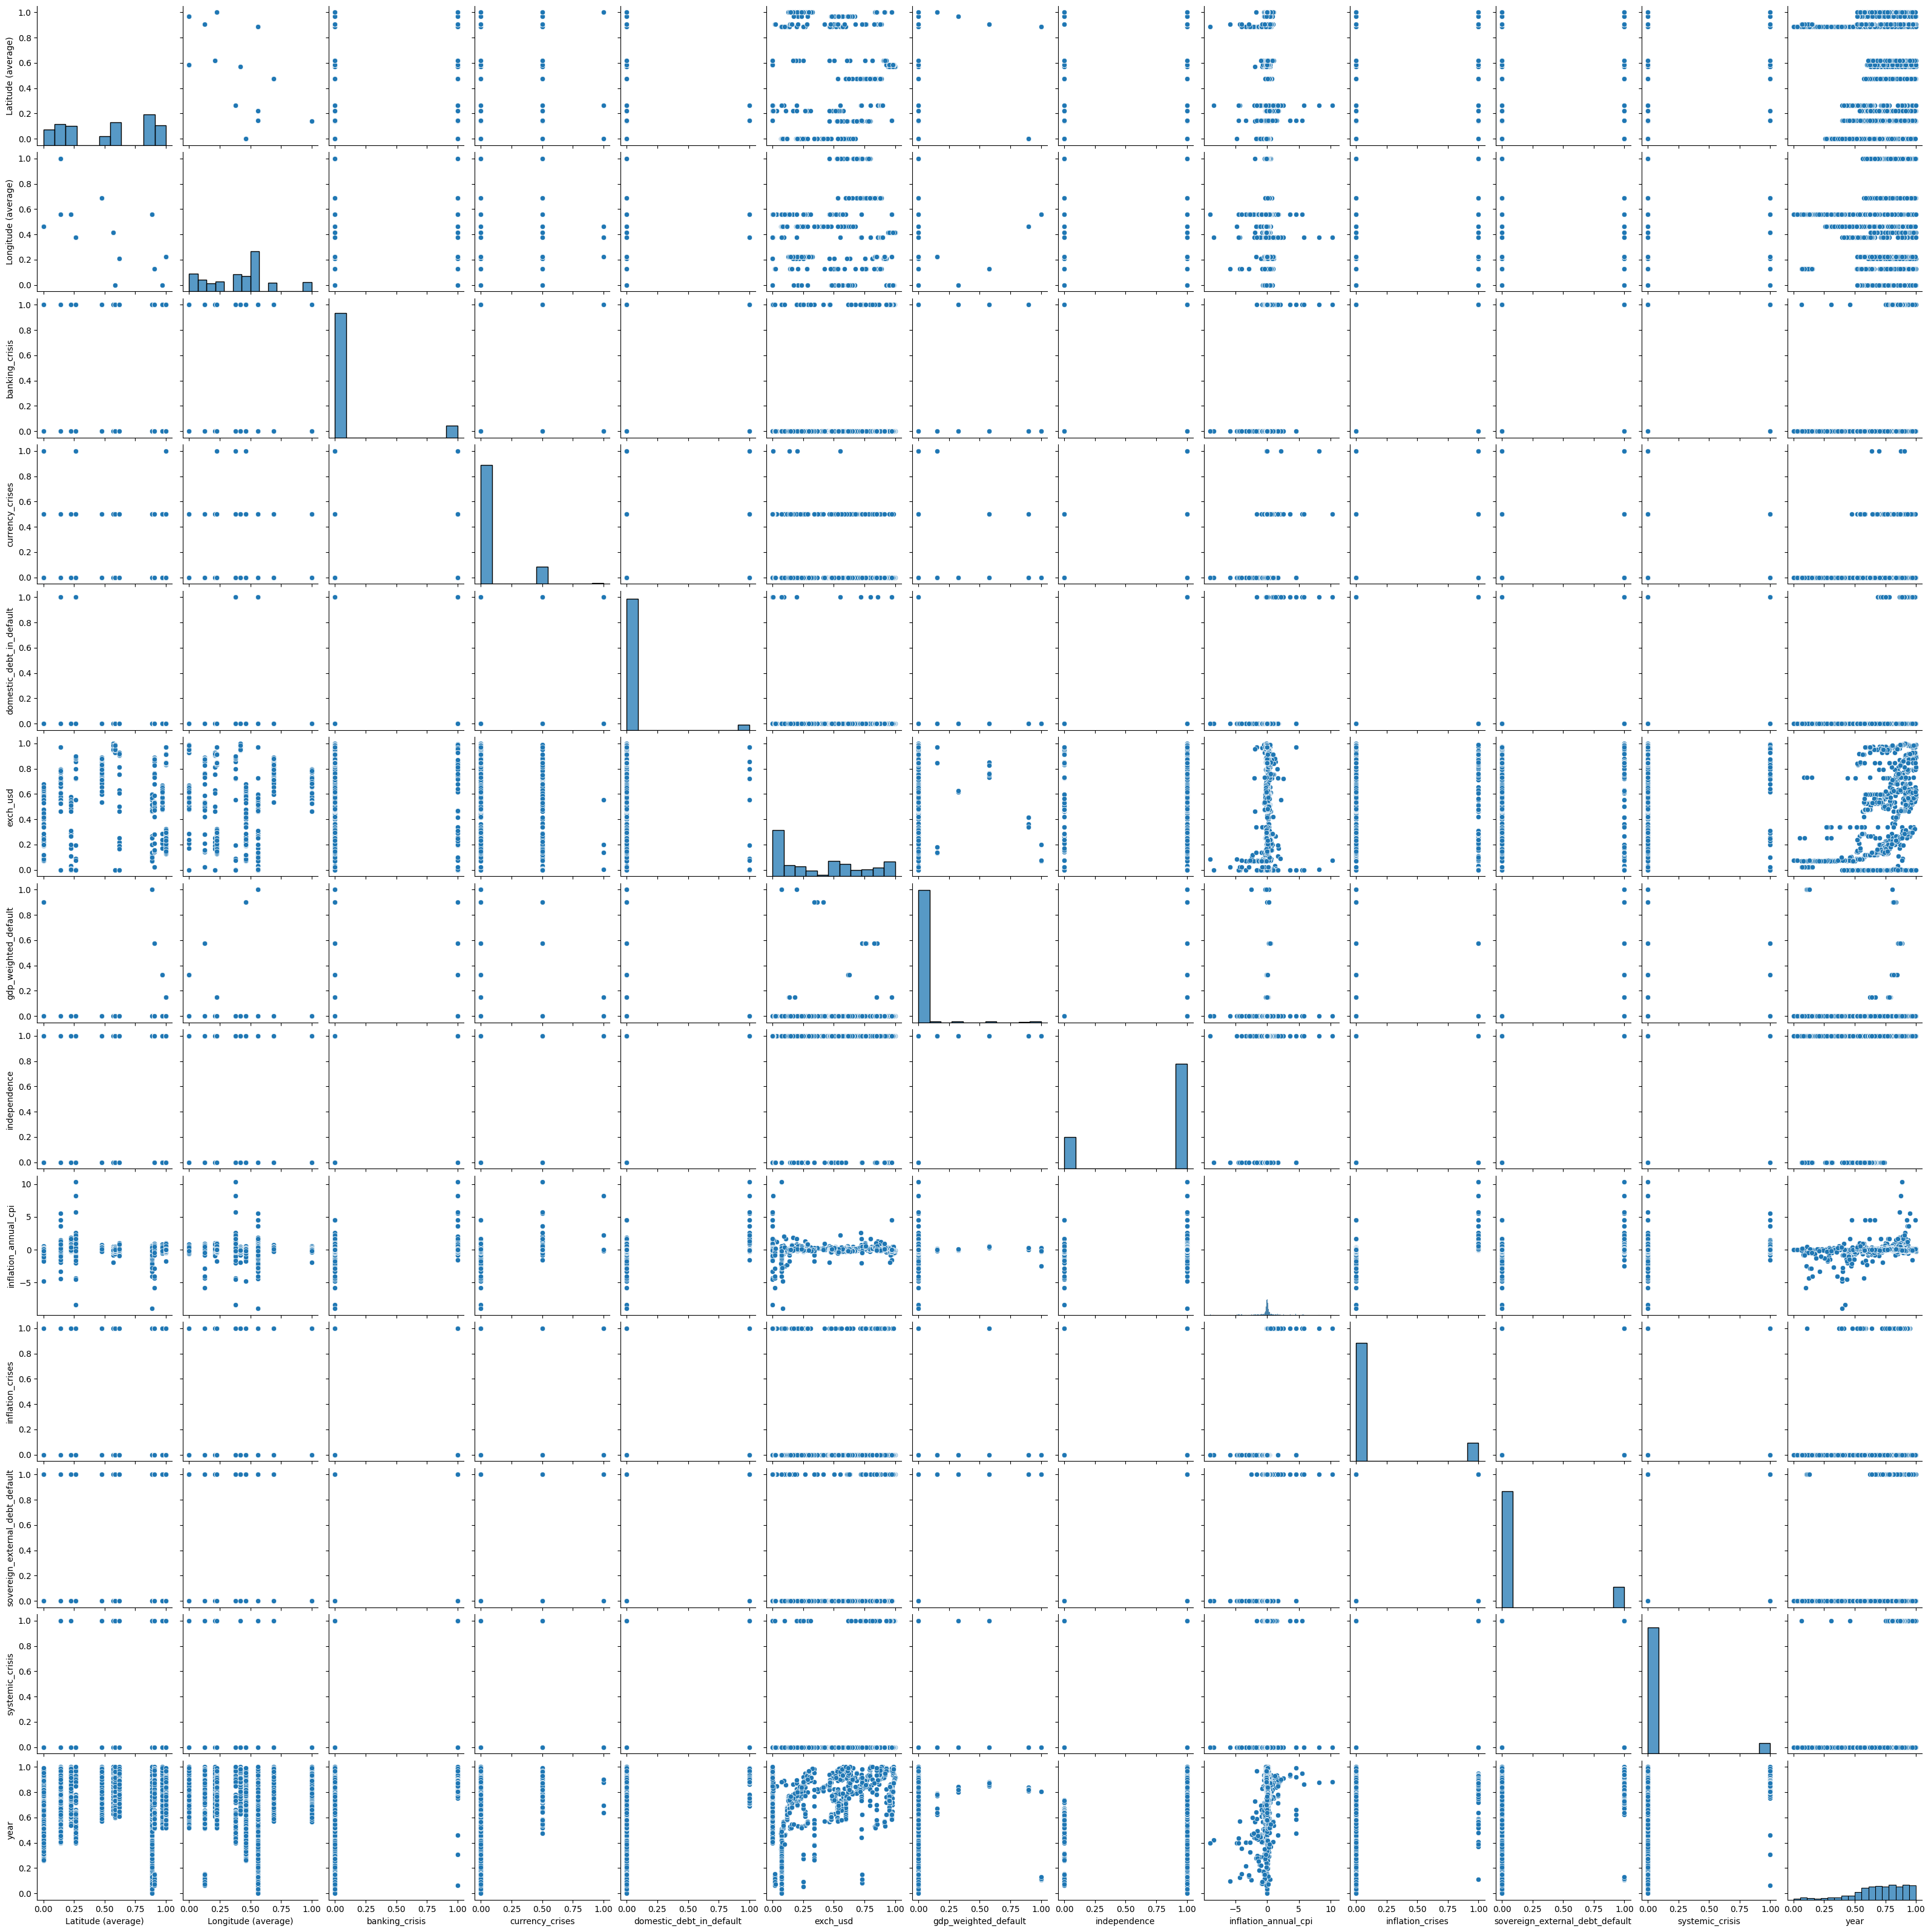

In [18]:
sns.pairplot(train_df)

Di seguito mostriamo la correlazione delle features con il target selezionato:

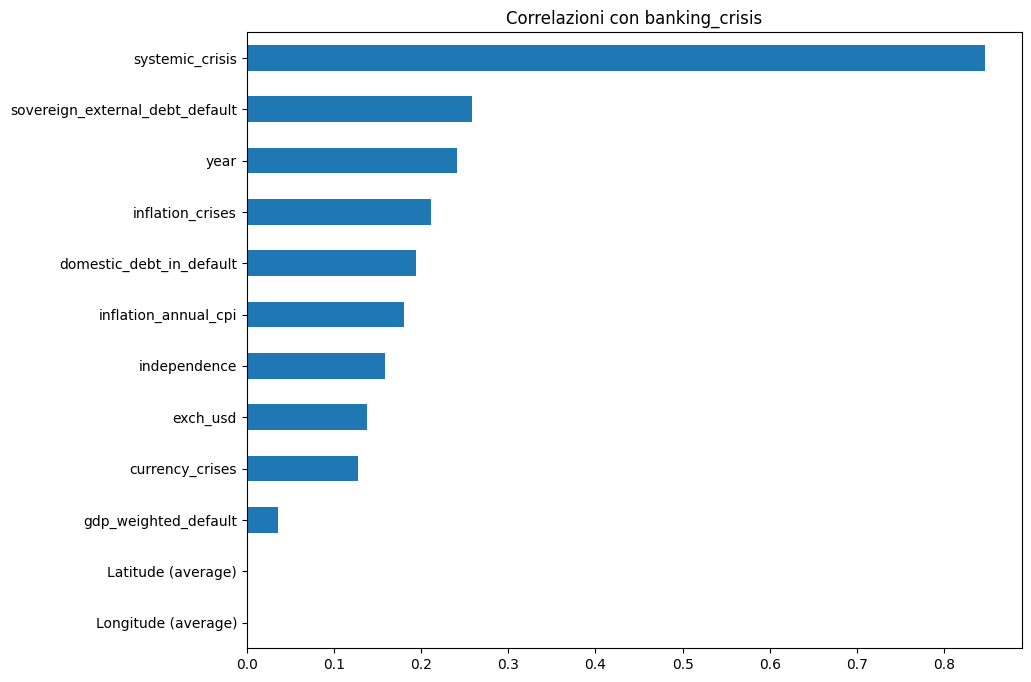

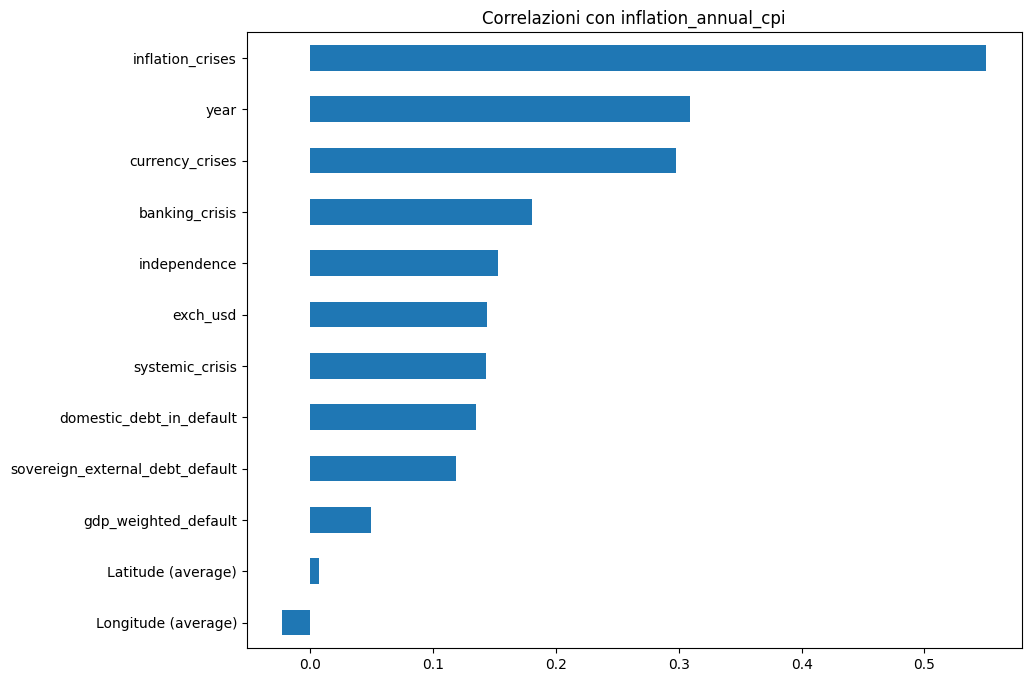

In [19]:
for target in targets:
    plt.figure()
    (  # Consideriamo il train set, TARGET escluso
        train_df.drop(target, axis=1)
        # Calcoliamo la correlazione di ciascuna feature con la colonna target
        .corrwith(train_df[target], method="spearman")
        # Ordiniamo le feature per correlazione decrescente
        .sort_values()
        # mostriamo un grafico a barre orizzontali di questi valori
        .plot.barh(figsize=[10, 8])
    )
    plt.title(f"Correlazioni con {target}")

Ora visualizziamo la distribuzione del target in due modi utilizzando i metodi di visualizzazione dei DataFrame Pandas `.plot.pie` per diagrammi a torta e `plot.bar` per diagrammi a barre verticali.

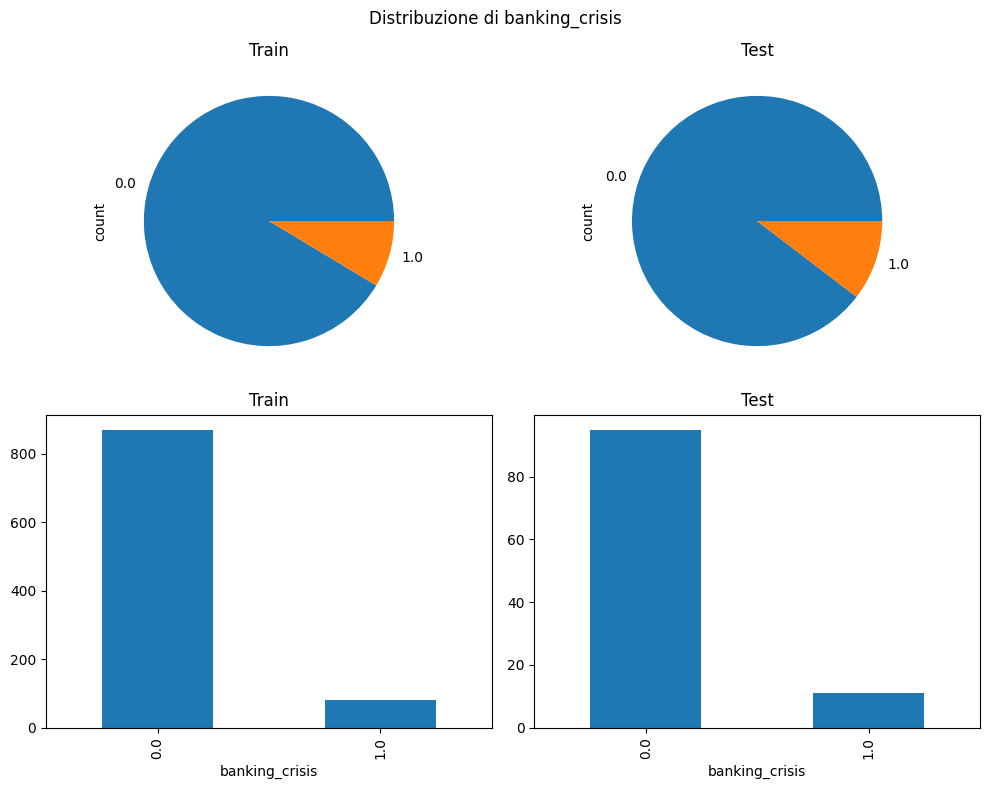

Text(0.5, 0.98, 'Distribuzione di inflation_annual_cpi')

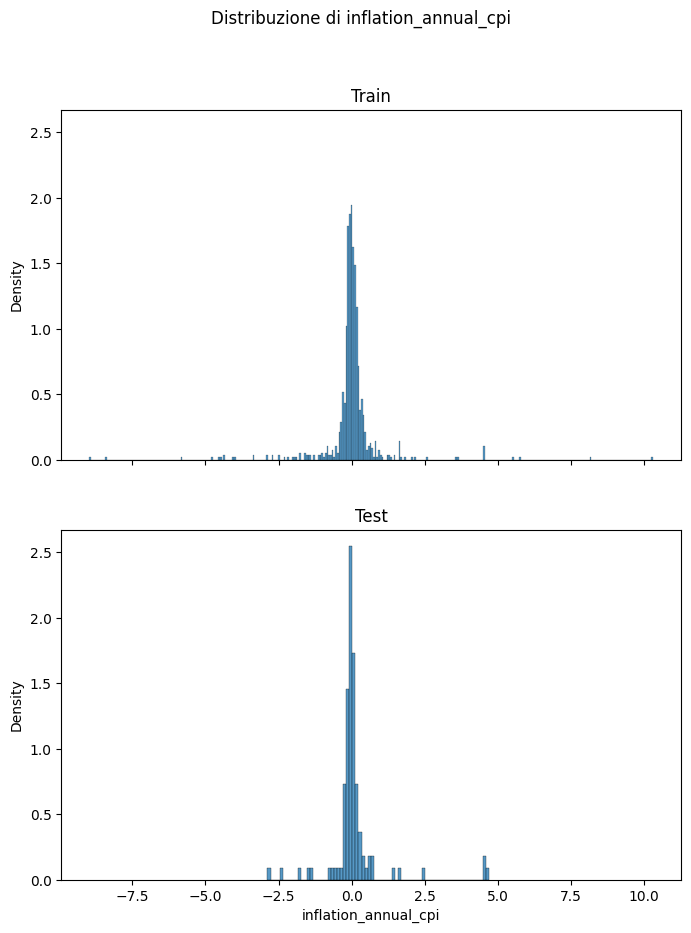

In [20]:
fig, (row0, row1) = plt.subplots(2, 2, figsize=[10, 8])
train_df[CLASSIFICATION_TARGET].value_counts().plot.pie(ax=row0[0], title="Train")
test_df[CLASSIFICATION_TARGET].value_counts().plot.pie(ax=row0[1], title="Test")
train_df[CLASSIFICATION_TARGET].value_counts().plot.bar(ax=row1[0], title="Train")
test_df[CLASSIFICATION_TARGET].value_counts().plot.bar(ax=row1[1], title="Test")
fig.suptitle(f"Distribuzione di {CLASSIFICATION_TARGET}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, figsize=[8,10], sharex=True, sharey=True)
sns.histplot(train_df, x=REGRESSION_TARGET, stat="density", ax=axs[0])
axs[0].set_title("Train")
sns.histplot(test_df, x=REGRESSION_TARGET, stat="density", ax=axs[1])
axs[1].set_title("Test")
fig.suptitle(f"Distribuzione di {REGRESSION_TARGET}")

Osserviamo ora l'`inflation_annual_cpi` medio per anno:

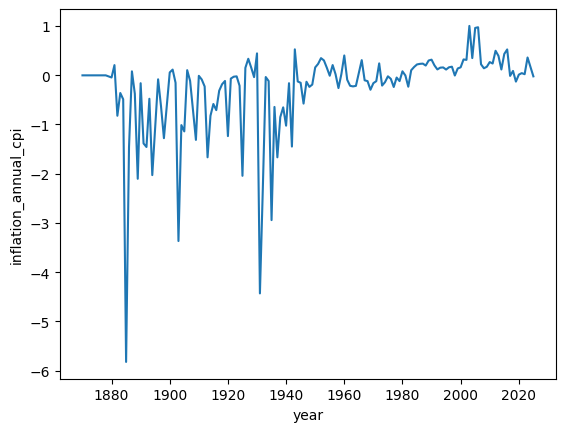

In [21]:
# Aggreghiamo per anno e calcoliamo la media delle features
agg_df = train_df.groupby(["year"]).mean().reset_index()
# Riscriviamo l'anno nella forma originale
agg_df["year"]= agg_df["year"].apply(lambda x: int(155*x)+1870)
# Rappresentiamo `inflation_annual_cpi` per anno
fig, ax = plt.subplots()
sns.lineplot(agg_df,x="year", y="inflation_annual_cpi", ax = ax)
plt.show()

E la distribuzione di `banking_crisis` per anno:

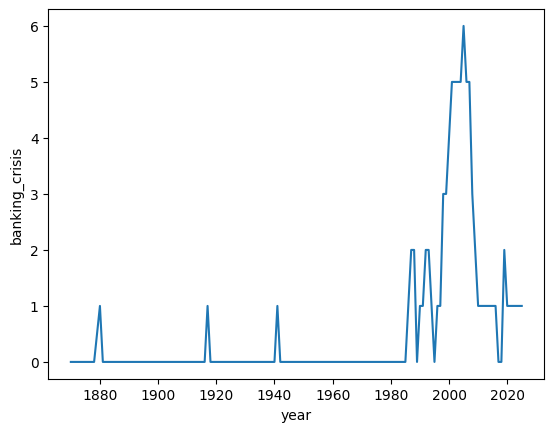

In [22]:
agg_df = train_df.groupby(["year"]).sum().reset_index()
agg_df["year"]= agg_df["year"].apply(lambda x: int(155*x)+1870)
sns.lineplot(agg_df,x="year", y="banking_crisis")
plt.show()

# Classificazione

In questa sezione applicheremo alcuni modelli di classificazione per il nostro target binario, `banking_crisis`.

## Estrazione della variabile target

In questo notebook scegliamo come variabile target `banking_crisis`, la variabile binaria che identifica le osservazioni in cui è in corso una crisi bancaria nel paese. A tal fine separiamo tale colonna dalle feature.

In [56]:
# Definiamo una funzione per lo split
def xy_split(df, target_column):
    x = df.drop(columns=target_column)
    y = df[target_column]
    return x, y


# Separiamo target_column dalle altre feature
X_train, y_train = xy_split(train_df, CLASSIFICATION_TARGET)
X_test, y_test = xy_split(test_df, CLASSIFICATION_TARGET)

# Controlliamo quali colonne sono presenti nel DataFrame e nella Series risultanti
print("Features: ",list(X_train.columns))
print("*"*79)
print("Target: ",y_train.name)

Features:  ['Latitude (average)', 'Longitude (average)', 'currency_crises', 'domestic_debt_in_default', 'exch_usd', 'gdp_weighted_default', 'independence', 'inflation_annual_cpi', 'inflation_crises', 'sovereign_external_debt_default', 'systemic_crisis', 'year']
*******************************************************************************
Target:  banking_crisis


## Modelli

Adesso andremo ad allenare diversi modelli di classificazione usando il nostro train set e testando le performance sul test set.

### Regressione Logistica

Partiamo da uno dei modelli più semplici: la regressione logistica. Utilizzeremo l'implementazione presente nella libreria `scikit-learn`.

In [57]:
from sklearn.linear_model import LogisticRegression

# Mostriamo alcuni parametri rilevanti
log_reg = LogisticRegression(
    # Termine di regolarizzazione: può essere "l1", "l2", o "elasticnet" (entrambi i termini inclusi)
    penalty="l2", 
    # Stato del generatore di numeri casuali utilizzato dall'oggetto. Utile fissarlo per replicabilità 
    # dei risultati
    random_state=42, 
    # Algoritmo di fitting del modello. Alcune opzioni sono ristrette ad alcuni valori di questa variabile.
    solver="lbfgs",        
    # Massimo numero di iterazioni dell'algoritmo di fitting. Conviene partire dal default 
    # e aumentarlo nel caso non l'algoritmo non converga.
    max_iter=100, 
    # Stampa informazioni durante l'esecuzione.
    verbose=False,   
    # Se penalty='elasticnet' permette di scegliere il rapporto fra i pesi dei due termini 
    # di regolarizzazione.
    l1_ratio=None,              
)

# Alleniamo il modello sul train set
log_reg.fit(X_train, y_train)

# Otteniamo le previsioni sul test set e conserviamole per dopo
prob_train_log_reg = log_reg.predict_proba(X_train)[:, 1]
pred_train_log_reg = log_reg.predict(X_train)
prob_test_log_reg = log_reg.predict_proba(X_test)[:, 1]
pred_test_log_reg = log_reg.predict(X_test)

### SVC

Come noto, possiamo usare un modello di tipo Support Vector Machine per la classificazione desiderata. Useremo `SVC`, una delle implementazioni della classe di modelli disponibile in `scikit-learn` (le altre sono `NuSVC`, implementata con una logica diversa, e `LinearSVC`, più veloce ma ristretta a kernel lineari).

In [58]:
from sklearn.svm import SVC

# Mostriamo alcuni parametri rilevanti per SVC
svc = SVC(
    # Il parametro di regolarizzazione. La forza della regolarizzazione è inversamente proporzionale a C. La penalità è una penalità l2 quadrata.
    C=1.0, 
    # Il tipo di kernel da utilizzare nell'algoritmo. Se nessuno è dato, verrà utilizzato 'rbf'.
    kernel='rbf', 
    # Coefficiente del kernel per 'rbf', 'poly' e 'sigmoid'. 
    # Se gamma='scale' (default) viene passato allora usa 1 / (n_features * X.var ()) come valore di gamma, 
    # se 'auto', usa 1 / n_features se float, deve essere non negativo.
    gamma='scale', 
    # Termine indipendente nella funzione del kernel. È significativo solo in 'poly' e 'sigmoid'.
    coef0=0.0, 
    # Se True, abilita la probabilità stimata tramite cross-validation 5-fold, che rallenta l'addestramento del modello ma consente di chiamare il metodo predict_proba.
    probability=True, 
    # Lo stato del generatore di numeri casuali utilizzato dall'oggetto.
    random_state=None,              
)

# Alleniamo il modello sul train set
svc.fit(X_train, y_train)

# Otteniamo le previsioni sul test set e conserviamole per dopo
prob_train_svc = svc.predict_proba(X_train)[:, 1]
pred_train_svc = svc.predict(X_train)
prob_test_svc = svc.predict_proba(X_test)[:, 1]
pred_test_svc = svc.predict(X_test)

### Random Forest

Per preparare un modello di tipo random forest useremo la classe `RandomForestClassifier` di `scikit-learn`.

In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    # Numero di alberi nella foresta
    n_estimators=100,  
    # Profondità massima dell'albero
    max_depth=5,  
    # Numero minimo di campioni richiesti per dividere un nodo interno
    min_samples_split=5,  
    # Numero minimo di campioni richiesti per essere un nodo foglia
    min_samples_leaf=2,
    # Numero di features da considerare quando si cerca la divisione migliore
    max_features='sqrt',
)

# Alleniamo il modello
rfc.fit(X_train, y_train)

# Otteniamo le previsioni sul test set e conserviamole per dopo
prob_train_rfc = rfc.predict_proba(X_train)[:, 1]
pred_train_rfc = rfc.predict(X_train)
prob_test_rfc = rfc.predict_proba(X_test)[:, 1]
pred_test_rfc = rfc.predict(X_test)

### Boosted Trees

Esistono diverse librerie per l'implementazione di modelli di tipo boosted trees, le più utilizzate sono:

- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://catboost.ai/)
- [CatBoost](https://lightgbm.readthedocs.io/en/stable/)

Noi utilizzeremo le classi messe a disposizione da XGBoost, in ogni caso le altre librerie non hanno sintassi molto diverse.


In [60]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(
    # Numero di alberi di boosting del gradiente
    n_estimators=100,  
    # Profondità massima di ogni albero
    max_depth=6,  
    # Tasso di apprendimento per il boosting del gradiente
    learning_rate=0.01,  
    # Rapporto di sottocampionamento delle istanze di addestramento
    subsample=1.0,  
    # Rapporto di sottocampionamento delle colonne durante la costruzione di ogni albero
    colsample_bytree=1.0,  
)

xgbc.fit(X_train, y_train)

prob_train_xgbc = xgbc.predict_proba(X_train)[:, 1]
pred_train_xgbc = xgbc.predict(X_train)
prob_test_xgbc = xgbc.predict_proba(X_test)[:, 1]
pred_test_xgbc = xgbc.predict(X_test)

## Metriche per modelli di classificazione

Qui mostreremo e rappresenteremo graficamente le più comuni metriche per modelli di classificazione:

- Matrice di classificazione
- Accuracy
- Precision
- Recall
- F1 score
- ROC/AUC

Partiamo con la matrice di confusione.

Text(0.5, 0.98, 'Test')

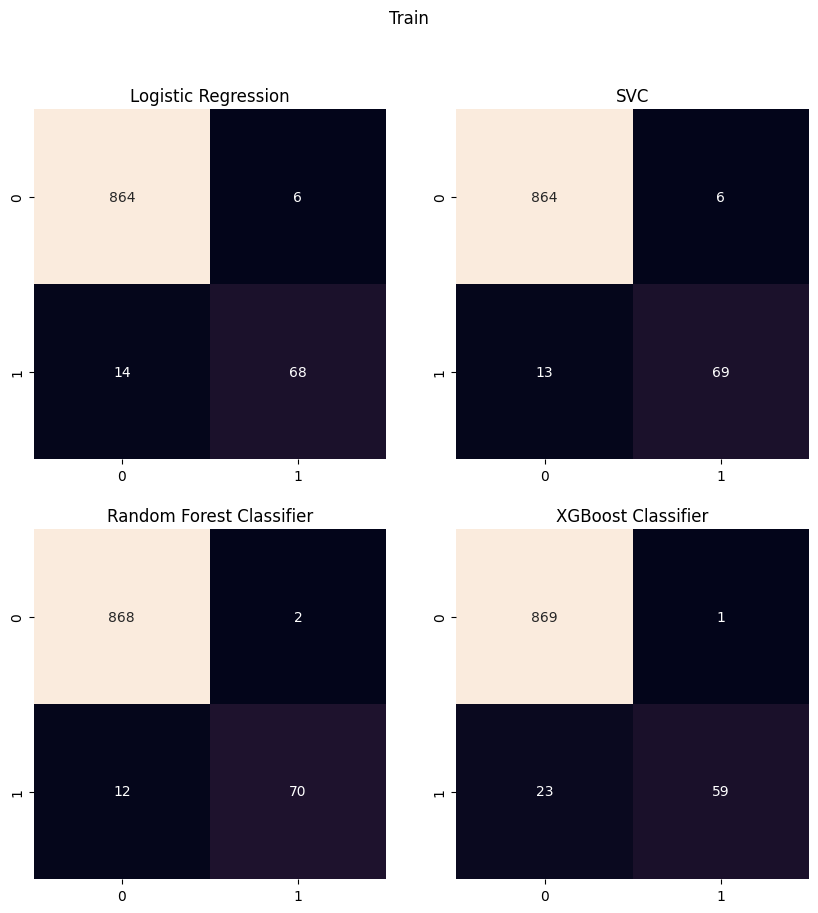

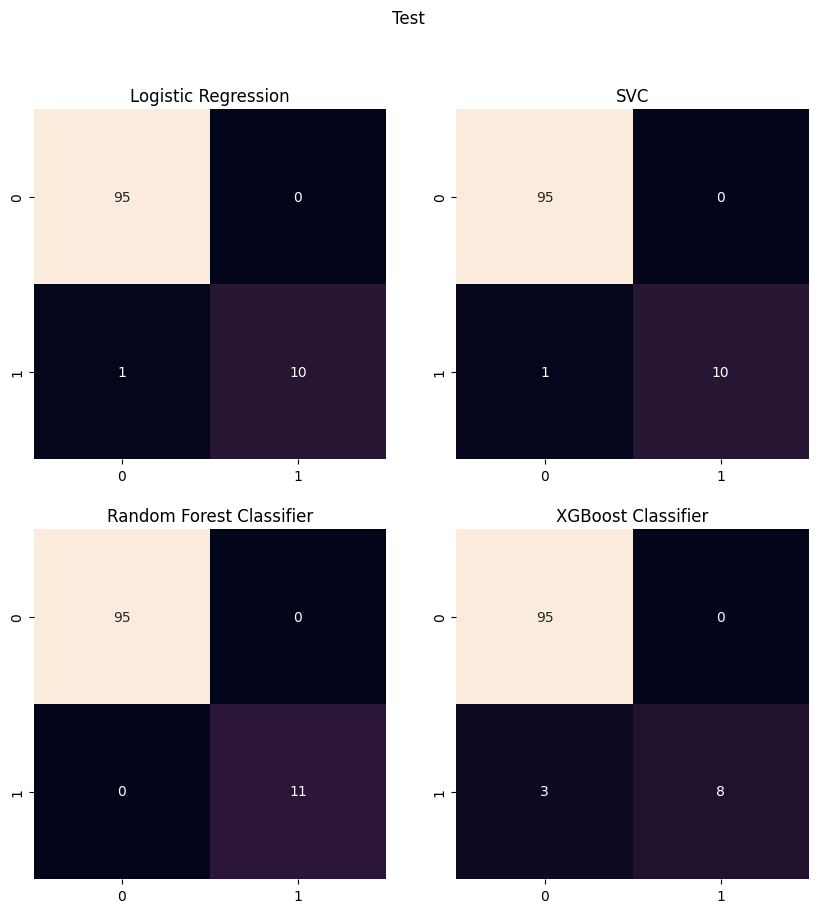

In [62]:
from sklearn.metrics import confusion_matrix
prob_train_results = [prob_train_log_reg, prob_train_svc, prob_train_rfc, prob_train_xgbc]
pred_train_results = [pred_train_log_reg, pred_train_svc, pred_train_rfc, pred_train_xgbc]
prob_test_results = [prob_test_log_reg, prob_test_svc, prob_test_rfc, prob_test_xgbc]
pred_test_results = [pred_test_log_reg, pred_test_svc, pred_test_rfc, pred_test_xgbc]
model_names = ["Logistic Regression", "SVC", "Random Forest Classifier", "XGBoost Classifier"]

fig, axes = plt.subplots(2, 2, figsize=[10,10])
axes = axes.flatten()

for index, prediction_result in enumerate(pred_train_results):
    pred_confusion_matrix = confusion_matrix(y_train, prediction_result)
    
    ax = sns.heatmap(
        pred_confusion_matrix, 
        ax=axes[index], 
        annot=True, 
        fmt='.0f', 
        cbar=False
    )
    ax.set(title=model_names[index])

fig.suptitle("Train")

fig, axes = plt.subplots(2, 2, figsize=[10,10])
axes = axes.flatten()

for index, prediction_result in enumerate(pred_test_results):
    pred_confusion_matrix = confusion_matrix(y_test, prediction_result)
    
    ax = sns.heatmap(
        pred_confusion_matrix, 
        ax=axes[index], 
        annot=True,
        fmt='.0f', 
        cbar=False
    )
    ax.set(title=model_names[index])

fig.suptitle("Test")

Proseguiamo con gli score: `scikit-learn` mette a disposizione una funzione, `classification_report`, che permette di ottenere una serie di metriche in maniera facile e ordinata:

In [63]:
from sklearn.metrics import classification_report

for index, prediction_result in enumerate(pred_train_results):
    print("-"*60)
    print(model_names[index]+" - Train set")
    print(classification_report(y_train, prediction_result))

for index, prediction_result in enumerate(pred_test_results):
    print("-"*60)
    print(model_names[index]+" - Test set")
    print(classification_report(y_test, prediction_result))

------------------------------------------------------------
Logistic Regression - Train set
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       870
         1.0       0.92      0.83      0.87        82

    accuracy                           0.98       952
   macro avg       0.95      0.91      0.93       952
weighted avg       0.98      0.98      0.98       952

------------------------------------------------------------
SVC - Train set
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       870
         1.0       0.92      0.84      0.88        82

    accuracy                           0.98       952
   macro avg       0.95      0.92      0.93       952
weighted avg       0.98      0.98      0.98       952

------------------------------------------------------------
Random Forest Classifier - Train set
              precision    recall  f1-score   support

         0.0       0.99

Possiamo anche concentrarci sulla singola metrica, importando la funzione adeguata da `sklearn.metrics` o creandola noi. In questo caso lavoreremo con l'F1 score.

In [64]:
from sklearn.metrics import f1_score

f1_train_scores = dict()
f1_test_scores = dict()

for index, prediction_result in enumerate(pred_train_results):
    f1_train_scores[model_names[index]] = f1_score(y_train, prediction_result, average='macro')
for index, prediction_result in enumerate(pred_test_results):
    f1_test_scores[model_names[index]] = f1_score(y_test, prediction_result, average='macro')

pd.DataFrame({"train": f1_train_scores, "test": f1_test_scores})

,train,test
Logistic Regression,0.930177,0.973573
SVC,0.934053,0.973573
Random Forest Classifier,0.950545,1.000000
XGBoost Classifier,0.908683,0.913281


Infine consideriamo la curva ROC e l'AUC score.

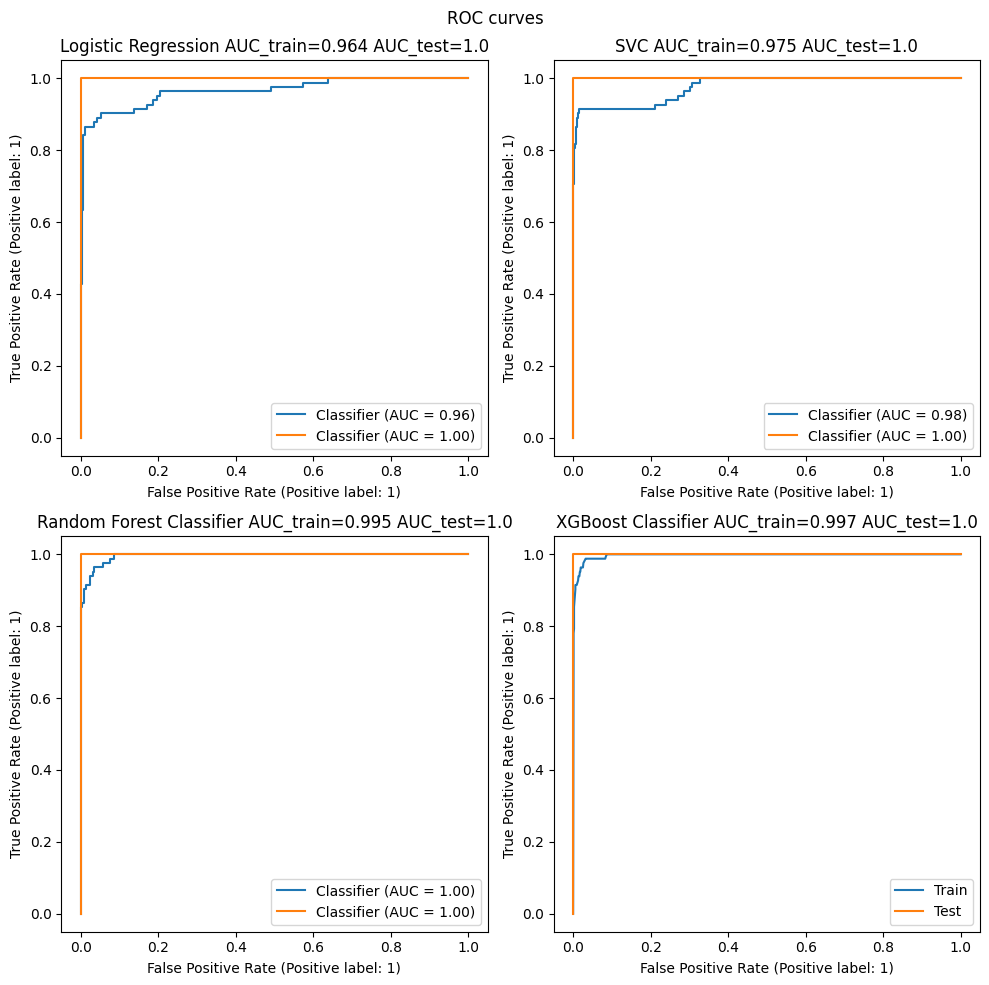

In [65]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

fig, ax = plt.subplots(2, 2, figsize=[10,10])
ax = ax.flatten()

for index, result in enumerate(prob_train_results):
    RocCurveDisplay.from_predictions(y_train, result, ax=ax[index])
    ax[index].set(title=model_names[index]+ f" AUC_train={round(roc_auc_score(y_train, result), 3)} AUC_test={round(roc_auc_score(y_test, prob_test_results[index]), 3)}")
for index, result in enumerate(prob_test_results):
    RocCurveDisplay.from_predictions(y_test, result, ax=ax[index])

plt.suptitle("ROC curves")
plt.legend(["Train", "Test"])
plt.tight_layout()
plt.show()

# Regressione

Ora ci occupiamo di modellizare il target `inflation_annual_cpi` utilizzando diversi modelli di regressione. Prima di tutto rifacciamo lo split del nostro dataset con la nuova variabile target.

In [67]:
# Separiamo target_column dalle altre feature
X_train, y_train = xy_split(train_df, REGRESSION_TARGET)
X_test, y_test = xy_split(test_df, REGRESSION_TARGET)

# Controlliamo quali colonne sono presenti nel DataFrame e nella Series risultanti
print("Features: ",list(X_train.columns))
print("*"*79)
print("Target: ",y_train.name)

Features:  ['Latitude (average)', 'Longitude (average)', 'banking_crisis', 'currency_crises', 'domestic_debt_in_default', 'exch_usd', 'gdp_weighted_default', 'independence', 'inflation_crises', 'sovereign_external_debt_default', 'systemic_crisis', 'year']
*******************************************************************************
Target:  inflation_annual_cpi


## Modelli
### Regressione Lineare

Per prima cosa applichiamo il modello `LinearRegression` dalla libreria `scikit-learn`.

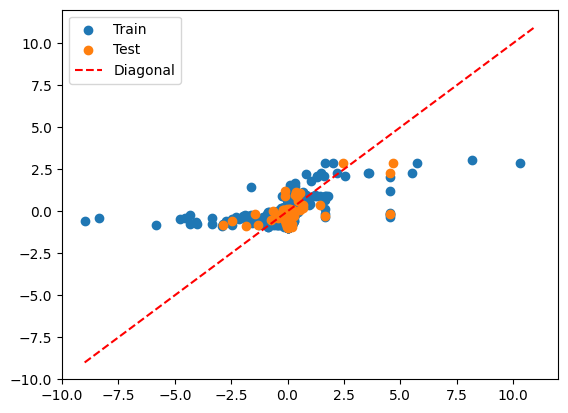

In [75]:
from sklearn.linear_model import LinearRegression

# Mostriamo alcuni parametri rilevanti
lin_reg = LinearRegression(
    # Se calcolare o meno il termine di intercetta per questo modello. 
    # Se impostato su False, nessuna intercetta verrà utilizzata nei calcoli (cioè si suppone che i dati siano già centrati).
    fit_intercept=True, 
    # Se True, X verrà copiato; altrimenti, potrebbe essere sovrascritto.
    copy_X=True, 
    # Il numero di lavori da utilizzare per il calcolo. Questo fornirà un aumento di velocità solo in caso di problemi sufficientemente grandi.
    n_jobs=None, 
    # Quando impostato su True, costringe i coefficienti ad essere positivi. Questa opzione è supportata solo per matrici dense.
    positive=False,              
)

lin_reg.fit(X_train, y_train)

pred_train_lin_reg = lin_reg.predict(X_train)
pred_test_lin_reg = lin_reg.predict(X_test)

fig, ax = plt.subplots()
plt.scatter(y_train, pred_train_lin_reg)
plt.scatter(y_test, pred_test_lin_reg)
ax.plot(range(-9,12),range(-9,12), linestyle="dashed", color="red")
plt.legend(["Train","Test", "Diagonal"])

### Regolarizzazione

Spesso possiamo ottenere risultati migliori regolarizzando i coefficienti della regressione con penalità L^1 (Lasso), L^2 (Ridge) o entrambe (Elastic net). Per includere tutti i casi di regolarizzazione useremo la classe `ElasticNet` di `scikit-learn`

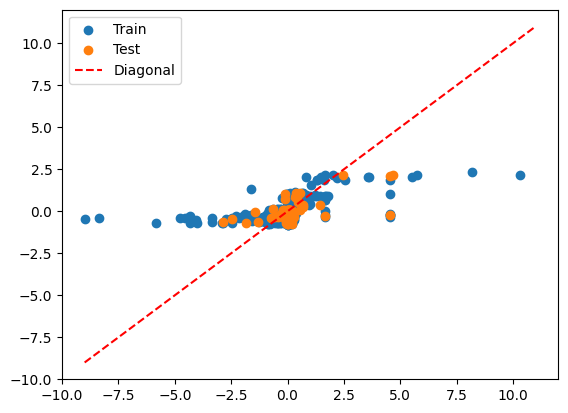

In [76]:
from sklearn.linear_model import ElasticNet

# Mostriamo alcuni parametri rilevanti
elastic_net = ElasticNet(
    # Costante che moltiplica i termini di penalità. I valori di alpha più grandi specificano una penalizzazione più forte. 
    # alpha = 0 è equivalente a una regressione lineare ordinaria, risolta dall'oggetto LinearRegression.
    alpha=0.01, 
    # Il parametro di mixing ElasticNet, con 0 <= l1_ratio <= 1. Per l1_ratio = 0 la penalità è una penalità L2. 
    # Per l1_ratio = 1 è una penalità L1. Per 0 < l1_ratio < 1, la penalità è una combinazione di L1 e L2.
    l1_ratio=0.5, 
    # Se calcolare o meno il termine di intercetta per questo modello. 
    # Se impostato su False, nessuna intercetta verrà utilizzata nei calcoli (cioè si suppone che i dati siano già centrati).
    fit_intercept=True, 
    # Se True, X verrà copiato; altrimenti, potrebbe essere sovrascritto.
    copy_X=True, 
    # Quando impostato su True, costringe i coefficienti ad essere positivi.
    positive=False,
)

elastic_net.fit(X_train, y_train)

pred_train_elastic_net = elastic_net.predict(X_train)
pred_test_elastic_net = elastic_net.predict(X_test)

fig, ax = plt.subplots()
plt.scatter(y_train, pred_train_elastic_net)
plt.scatter(y_test, pred_test_elastic_net)
ax.plot(range(-9,12),range(-9,12), linestyle="dashed", color="red")
plt.legend(["Train","Test", "Diagonal"])

### Random Forest

Possiamo utilizzare un modello di tipo Random Forest anche per il caso di regressione.

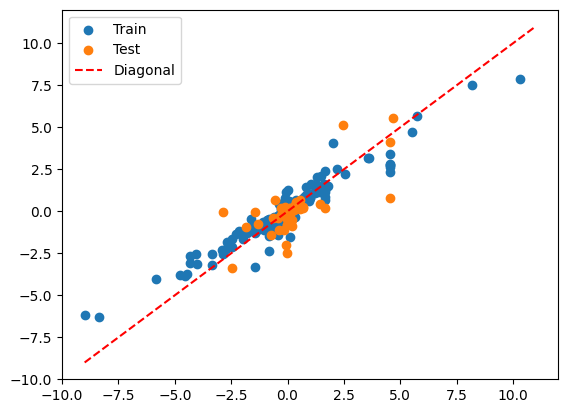

In [77]:
from sklearn.ensemble import RandomForestRegressor

# Mostriamo alcuni parametri rilevanti
rfr = RandomForestRegressor(
    # Il numero di alberi nella foresta.
    n_estimators=100, 
    # La funzione per misurare la qualità di una divisione. I criteri supportati sono "squared_error" per l'errore quadratico medio, "absolute_error" per l'errore assoluto medio e "poisson" per la devianza di Poisson.
    criterion="squared_error", 
    # La profondità massima dell'albero. Se None, allora i nodi vengono espansi fino a quando tutte le foglie sono pure o fino a quando tutte le foglie contengono meno di min_samples_split campioni.
    max_depth=None, 
    # Il numero di funzioni da considerare quando si cerca la migliore divisione.
    max_features="sqrt", 
    # Se utilizzare campioni fuori sacco (out-of-bag) per stimare l'errore di generalizzazione.
    oob_score=False, 
    # Lo stato del generatore di numeri casuali utilizzato dall'oggetto.
    random_state=None,              
)

rfr.fit(X_train, y_train)

pred_train_rfr = rfr.predict(X_train)
pred_test_rfr = rfr.predict(X_test)

fig, ax = plt.subplots()
plt.scatter(y_train, pred_train_rfr)
plt.scatter(y_test, pred_test_rfr)
ax.plot(range(-9,12),range(-9,12), linestyle="dashed", color="red")
plt.legend(["Train","Test", "Diagonal"])

### Boosted Trees

Infine applichiamo anche XGBoost al problema di regressione.

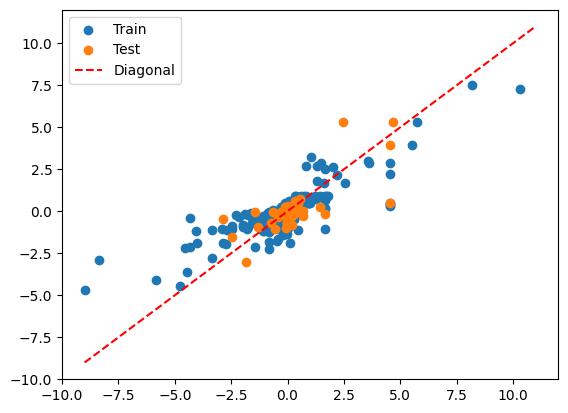

In [74]:
from xgboost import XGBRegressor

# Mostriamo alcuni parametri rilevanti
xgbr = XGBRegressor(
    # Il numero di alberi da stimare.
    n_estimators=100, 
    # Il tasso di apprendimento riduce il contributo di ogni albero di learning_rate. C'è un compromesso tra learning_rate e n_estimators.
    learning_rate=0.1, 
    # La profondità massima dell'albero. Aumentando questo valore renderà il modello più complesso e più propenso al sovradattamento.
    max_depth=3, 
    # Il parametro regolarizzazione L1 sui pesi. Aumentare questo valore renderà il modello più conservativo.
    reg_alpha=0, 
    # Il parametro regolarizzazione L2 sui pesi. Aumentare questo valore renderà il modello più conservativo.
    reg_lambda=1, 
    # Il seme per il generatore di numeri casuali.
    random_state=42,              
)

xgbr.fit(X_train, y_train)

pred_train_xgbr = xgbr.predict(X_train)
pred_test_xgbr = xgbr.predict(X_test)

fig, ax = plt.subplots()
plt.scatter(y_train, pred_train_xgbr)
plt.scatter(y_test, pred_test_xgbr)
ax.plot(range(-9,12),range(-9,12), linestyle="dashed", color="red")
plt.legend(["Train","Test", "Diagonal"])

Per simmetria del numero di modelli considerati abbiamo tralasciato le SVM mirate alla regressione, utilizzabili tramite la classe `SVR` di `scikit-learn`.

## Metriche

Ora consideriamo le più comuni metriche per modelli di regressione: 
- Mean Square Error (MSE)
- Root Mean Square Error (RMSE)
- Mean Absolute Error (MAE)

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def get_regression_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": (mean_squared_error(y_true, y_pred)) ** 0.5,
        "MAE": mean_absolute_error(y_true, y_pred),
    }


pred_train_results = [
    pred_train_lin_reg,
    pred_train_elastic_net,
    pred_train_rfr,
    pred_train_xgbr,
]
pred_test_results = [
    pred_test_lin_reg,
    pred_test_elastic_net,
    pred_test_rfr,
    pred_test_xgbr,
]
model_names = [
    "Linear Regression",
    "Elastic Net",
    "Random Forest Regressor",
    "XGBoost Regressor",
]

train_metrics, test_metrics = dict(), dict()
for index in range(len(model_names)):
    train_metrics[model_names[index]] = get_regression_metrics(
        y_train, pred_train_results[index]
    )
    test_metrics[model_names[index]] = get_regression_metrics(
        y_test, pred_test_results[index]
    )

train_metrics = pd.DataFrame(train_metrics).transpose()
test_metrics = pd.DataFrame(test_metrics).transpose()

train_metrics["dataset"] = "train"
test_metrics["dataset"] = "test"

regression_scores = (
    pd.concat([train_metrics, test_metrics], axis=0)
    .reset_index()
    .rename(columns={"index": "model"})
    .set_index(["model", "dataset"])
    .sort_values(by="model")
)

display(regression_scores)

MSE      RMSE       MAE
model                   dataset                              
Elastic Net             train    0.730868  0.854908  0.378291
                        test     0.600934  0.775199  0.409121
Linear Regression       train    0.719257  0.848090  0.399510
                        test     0.572681  0.756757  0.421180
Random Forest Regressor train    0.103248  0.321323  0.131612
                        test     0.529460  0.727640  0.366411
XGBoost Regressor       train    0.332843  0.576925  0.271954
                        test     0.458296  0.676975  0.337319